<div style="padding:30px; color: white; background-color: #0071CD">
<center>
<img src="img/logoub.jpeg"></img>
<center>
<h1>Algorísmica Avançada</h1>
<h2>Grafs de flux</h2>
</center>
</div>

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Màxim flux: l'algorisme Ford-Fulkerson

Considereu el següent graf dirigit. Està format per quatre nodes $S,U,V,T$ on $S$ representa el node origen (source) i $T$ representa el node destí (target).

Quin és el màxmim flux que podem transportar de $S$ a $T$?

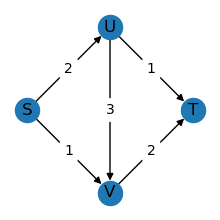

In [6]:
import networkx as nx
from matplotlib import pyplot as plt
from digraph_plot import my_draw_networkx_edge_labels

G = nx.DiGraph()
G.add_weighted_edges_from([('S','U',2), ('S','V',1), ('U', 'V', 3), ('V','T', 2), ('U','T',1)])

plt.figure(figsize=(2,2))
pos = {'S': [0,0.5], 'T':[1,0.5], 'U':[0.5, 1], 'V':[0.5,0]}
nx.draw(G, pos=pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=nx.get_edge_attributes(G, 'weight'), rotate=False)

plt.show()

Intentem resoldre-ho per passos:
1) Prenem l'aresta de major capacitat que surt de $S$. Aquesta aresta és $(S,U)$ que pot transportar 2.
2) Ara $U$ ha rebut 2 i pot escollir on enviar-los. Suposem que escollim enviar-los a $V$ que té la major capacitat.
3) Ara tenim 2 a $V$ encara que l'aresta per on hem passat podia transportar-ne més.
4) Finalment enviem els 2 a $T$ utilitzant l'aresta $(V,T)$.

Ens quedaria el camí:

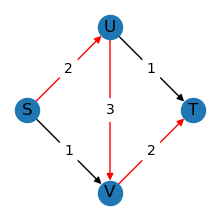

In [7]:
G = nx.DiGraph()
G.add_weighted_edges_from([('S','U',2), ('U', 'V', 3), ('V','T', 2)], color='r')
G.add_weighted_edges_from([('S','V',1), ('U','T',1)], color='k')

plt.figure(figsize=(2,2))
pos = {'S': [0,0.5], 'T':[1,0.5], 'U':[0.5, 1], 'V':[0.5,0]}
colors = [G.edges()[n]['color'] for n in G.edges()]
nx.draw(G, pos=pos, with_labels=True, edge_color=colors)
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=nx.get_edge_attributes(G, 'weight'), rotate=False)

plt.show()

És el màxim flux que podem transportar? ...Doncs NO!

Donat el camí anterior, podem construïr el __graf residual__. El graf residual ens permet saber el flux que hem gastat al transportar i quant ens en queda a les diferents arestes.

El graf residual per al camí anterior és:

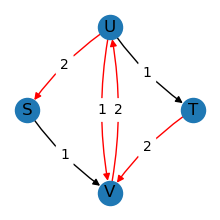

In [8]:
G = nx.DiGraph()
G.add_weighted_edges_from([('U','S',2), ('V', 'U', 2), ('T','V', 2), ('U','V',1)], color='r')
G.add_weighted_edges_from([('S','V',1), ('U','T',1)], color='k')

plt.figure(figsize=(2,2))
pos = {'S': [0,0.5], 'T':[1,0.5], 'U':[0.5, 1], 'V':[0.5,0]}
colors = [G.edges()[n]['color'] for n in G.edges()]
nx.draw(G, pos=pos, with_labels=True, edge_color=colors,connectionstyle='arc3, rad = 0.1')
my_draw_networkx_edge_labels(G, pos=pos, edge_labels=nx.get_edge_attributes(G, 'weight'), rad=0.1, rotate=False)

plt.show()

Observeu que hem 'girat' les arestes que transporten el maxim de la seva capacitat. Com que l'aresta $(U,V)$ transporta 2 tot i que pot transportar 3, mantenim 1 en la direcció original.

Tornem a buscar un camí de $S$ a $T$ sobre aquest graf residual. Observeu que n'existeix un que transporta flux 1 seguint el camí $S$, $V$, $U$, $T$.

Però com podem anar de $V$ a $U$ si en el graf original només podíem anar de $U$ a $V$? No és que poguem anar de $V$ a $U$ sino que, com que ho estem mirant en el graf residual, ens indica que per aquest camí ha de 'deixar de passar-hi' 1 unitat de flux. I això només es possible si, dels 2 que havíem rebut a $U$ n'enviem un directament a $T$ i l'altre l'enviem a $V$.

Així, el màxim de flux que podem transportar és 3:
- Enviem 2 unitats de $S$ a $U$.
    - 1 unitat l'enviem directament a $T$.
    - 1 unitat l'enviem a $V$.
    
- Enviem 1 unitat de S a $V$.
    - Recollim la unitat que venia de $U$ i n'enviem 2 a $T$.

# Problema 1
Repetiu manualment el procediment anterior amb el següent graf:<br>

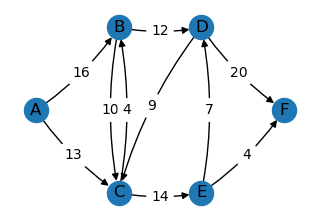

In [14]:
G = nx.DiGraph()
G.add_weighted_edges_from([("A","B",16),("A","C",13),("B","C",10),("C","B",4),("B","D",12),
                           ("C","E",14),("D","C",9),("E","D",7),("D","F",20),("E","F",4)])
plt.figure(figsize=(3,2))
pos = {"A": [0,0.5], "B":[0.25,1], "C":[0.25, 0], "D":[0.5,1], "E":[0.5,0], "F":[0.75,0.5]}
nx.draw(G, pos=pos, with_labels=True, connectionstyle='arc3, rad = 0.1')
my_draw_networkx_edge_labels(G, pos=pos, edge_labels=nx.get_edge_attributes(G, 'weight'), rad=0.1, rotate=False)

plt.show()

# Problema 2
Implementeu l'algorisme Ford-Fulkerson. Donat un graf dirigit sense cicles, l'algorisme ha de retornar el màxim flux que es pot transportar des del node 'source' fins al node 'target'. Podeu seguir l'esquema següent:
1) Inicialitzem el màxim flux que podem transportar            
2) Busquem un camí del node orígen al node destí. Podeu usar DFS o BFS. Si no existeix cap camí, l'algorisme acaba.
3) Augmentem el màxim flux transportat amb el valor mínim del camí que hem trobat.
4) Actualitzem els pesos i/o creem arestes per construïr el graf residual.
5) Tornem al punt 2.

In [15]:
def dfs_path(G, source, target, visited):
    """
    Aquesta funció construeix el camí de source a target usant DFS.
    En cas que no existeixi, retornarà False.
    """
    if source == target:
        return [target]

    if source not in visited:
        visited.add(source)

        for nei in G.neighbors(source):

            if G.edges()[(source,nei)]['weight'] > 0:
                pth = dfs_path(G, nei, target, visited)

                if pth:
                    return [source]+pth

    return False
    

def ford_fulkerson(G, source='S', target='T'):
    """
    Implementació de l'algorisme ford-fulkerson
    """
    # Punt 1. Guardem el màxim flux que podem transportar. Inicialment és zero
    maxflow = 0
    # OPCIONAL: Guardarem totes les iteracions de l'algorisme per veure com evoluciona el graf.
    graph_states = [G.copy()]
    # Comencem aplicant un DFS, construïnt el path
    pth = dfs_path(G, source, target, set())
    
    # Punt 2. Si existeix el path
    while pth:
        
        # Punt 3. Trobem l'aresta de pes mínim dins el camí i actualitzem el flux màxim
        minflow = min([G.edges()[(pth[i], pth[i+1])]['weight'] for i in range(len(pth)-1)])
        maxflow += minflow
        
        # Punt 4. Actualitzem el valor de les arestes
        for i in range(len(pth)-1):
            
            # L'aresta (i, i+1) sempre existeix ja que forma part del path
            G.edges()[(pth[i], pth[i+1])]['weight'] -= minflow
            
            # L'aresta (i+1, i) pot no existir ja que va en sentit contrari
            if (pth[i+1], pth[i]) not in G.edges():
                G.add_weighted_edges_from([(pth[i+1], pth[i], 0)])                    
            G.edges()[(pth[i+1], pth[i])]['weight'] += minflow
                
        graph_states.append(G.copy())      
        
        # Punt 5. Tornem al Punt 2 mentre existeixi camí de l'orígen al destí.
        pth = dfs_path(G, source, target, set())
        
    return maxflow, graph_states

Prova el teu algorisme:

In [16]:
G = nx.DiGraph()
G.add_weighted_edges_from([('S','U',2), ('S','V',1), ('U', 'V', 3), ('V','T', 2), ('U','T',1)])

maxflow, graph_states = ford_fulkerson(G)

In [17]:
dfs_path(G, 'S', 'T', set())

False

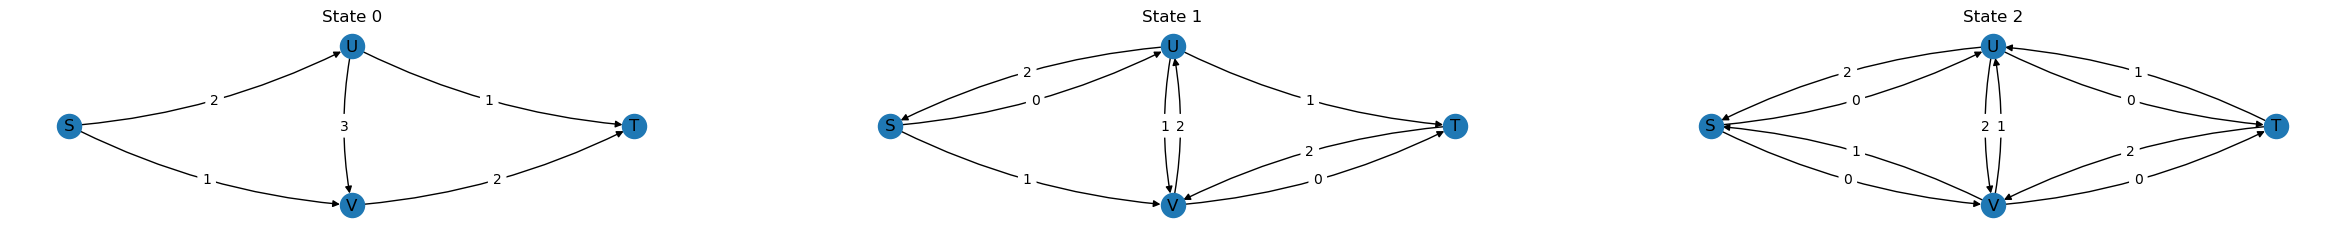

In [21]:
fig, axs = plt.subplots(1, len(graph_states), figsize=(30,2.5))
pos = {'S': [0,0.5], 'T':[1,0.5], 'U':[0.5, 1], 'V':[0.5,0]}

for idx, graph in enumerate(graph_states):
    nx.draw(graph, pos=pos, with_labels=True, connectionstyle='arc3, rad = 0.1', ax=axs[idx])
    my_draw_networkx_edge_labels(graph, pos=pos, edge_labels=nx.get_edge_attributes(graph, 'weight'),rad=0.1, rotate=False, ax=axs[idx])
    axs[idx].set_title(f'State {idx}')
plt.show()

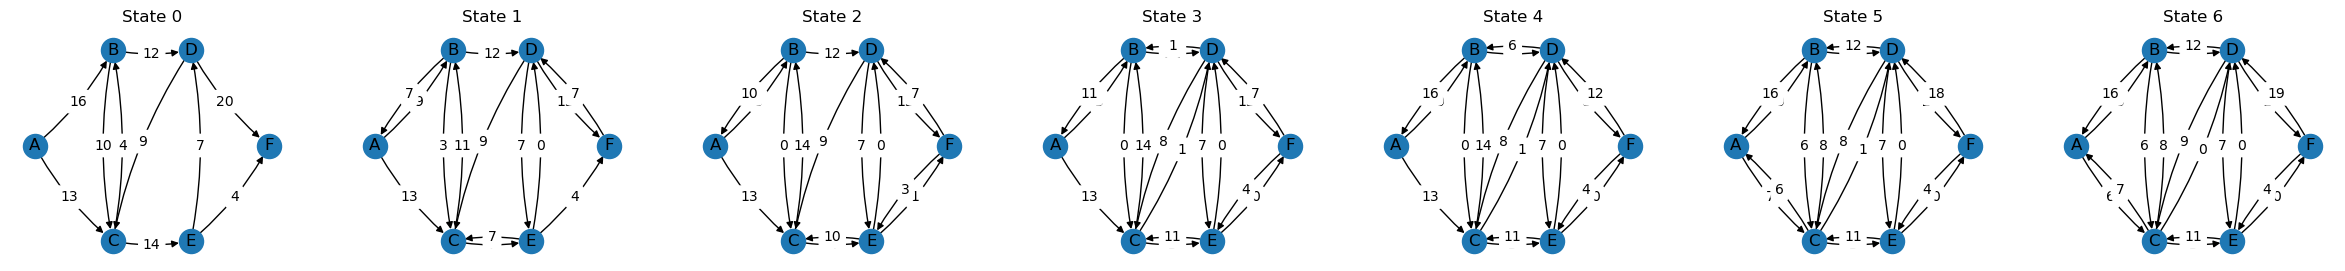

In [23]:
G = nx.DiGraph()
G.add_weighted_edges_from([("A","B",16),("A","C",13),("B","C",10),("C","B",4),("B","D",12),
                           ("C","E",14),("D","C",9),("E","D",7),("D","F",20),("E","F",4)])

pos = {"A": [0,0.5], "B":[0.25,1], "C":[0.25, 0], "D":[0.5,1], "E":[0.5,0], "F":[0.75,0.5]}
maxflow, graph_states = ford_fulkerson(G, source='A', target='F')

fig, axs = plt.subplots(1, len(graph_states), figsize=(30,3))
for idx, graph in enumerate(graph_states):
    nx.draw(graph, pos=pos, with_labels=True, connectionstyle='arc3, rad = 0.1', ax=axs[idx])
    my_draw_networkx_edge_labels(graph, pos=pos, edge_labels=nx.get_edge_attributes(graph, 'weight'),rad=0.1, rotate=False, ax=axs[idx])
    axs[idx].set_title(f'State {idx}')
plt.show()

# Problema 3
Considera un conjunt de $p$ professors, $P=\{P_1,\dots,P_p\}$ i un conjunt de $a$ assignatures: $A=\{A_1,\dots,A_a\}$. Cada professor té un subconjunt d'assignatures preferides. Per exemple, el professor $P_1$ té com a assignatures preferides: $F_1 = \{A_1, A_2, A_3\}$. Formalment podem definir el conjunt d'assignatures preferides del professor $P_q$ com: $F_q\subset A$ on $q\leq p$.<br><br>
    Implementa un algorisme que generi el màxim nombre de parelles (professor, assignatura), tenint en compte que tots els professors només poden donar una sola assignatura i que ha de ser una de les seves preferides.


In [27]:
def dfs_explore(G,node,visited):
    # Si el node actual no està visitat, l'afegim
    if node not in visited:
        visited.append(node)
        # Per a cada veí del node actual, cridem de nou a la funció DFS per seguir visitant
        for nei in G.neighbors(node):
            if G[node][nei]['weight'] > 0:
                dfs_explore(G, nei, visited) 

In [30]:
#CODI NO EFICIENT
import itertools
def assignacio_professors(preferencies):
    """
    Solucioneu el problema de les assignacions. El diccionari 'preferencies' conté els professors com a claus
    i les seves preferències com a valors en forma de llista. Heu de maximitzar el nombre d'assignacions possibles.
    """
    num = 0
    values = list(preferencies.values())
    assignatures = set()
    for lista in values:
        assignatures.update(lista)
        
    profes = list(preferencies.keys())
    assignatures = list(assignatures)
    
    if(len(profes) != len(assignatures)):
        print(f'Assignacions possibles: {0}')
    else:
        mescla = list(itertools.permutations(profes))
        for ordre in mescla:
            solucio = ""
            res = True
            for i in range(len(ordre)):
                if assignatures[i] in preferencies[ordre[i]]:
                    solucio += f'{ordre[i]} -> {assignatures[i]} , '
                else:
                    res = False
                    break
            if res:
                print(solucio)
                num += 1
        print(f'Assignacions possibles: {num}')

In [31]:
preferencies = {'P1': ['A1', 'A2'],
                'P2': ['A1'],
                'P3': ['A1', 'A2', 'A3', 'A4'],
                'P4': ['A2', 'A3']}

# En aquest cas el teu algorisme ha d'assignar P1->A2, P2->A1, P3->A4, P4->A3
assignacio_professors(preferencies)

P1 -> A2 , P2 -> A1 , P3 -> A4 , P4 -> A3 , 
Assignacions possibles: 1


In [32]:
preferencies = {'P1': ['A1', 'A2'],
                'P2': ['A1'],
                'P3': ['A1', 'A2', 'A3', 'A4'],
                'P4': ['A2', 'A3'],
                'P5': ['A1'],
                'P6': ['A2','A3','A4']}

# En aquest cas el teu algorisme ha d'assignar P1->A2, P2->A1, P3->A4, P4->A3. P5 i P6 queden sense assignar
assignacio_professors(preferencies)

Assignacions possibles: 0


## MinCut

El ___minimum cut (mincut)___ d'un graf de flux és una partició dels seus vèrtex en dos conjunts disjunts. La partició ha de satisfer que el pes de totes les arestes que travessen el graf d'una partició a l'altre (en la mateixa direcció) sigui el menor possible.

Per a calcular el tall mínim usem l'algorisme Ford-Fulkerson fins a obtenir el graf residual. Un cop trobat aquest nou graf, apliquem un DFS des de l'orígen. Tots els nodes que es puguin assolir des del node orígen, formaran part d'una de les dues particions. Les arestes que connectin nodes d'aquesta partició amb nodes no assolibles, formaran part del tall del mincut.

# Problema 4
Implementeu l'algorisme mincut per a trobar la partició dels nodes del graf. Retorneu també les arestes que formen part del tall del mincut

In [35]:
def mincut(G, source, target):
    maxflow, graph_states = ford_fulkerson(G, source, target)
    Graf_i = graph_states[0]
    Graf_f = graph_states[-1]
    
    Gsource = []
    dfs_explore(Graf_f, source, Gsource)
    Gtarget= []
    for node in Graf_f.nodes():
        if node not in Gsource:
            Gtarget.append(node)
            
    
    mincut = []
    for node in Gsource:
        for nei in Graf_i.neighbors(node):
            if nei in Gtarget:
                mincut.append((node, nei, Graf_i[node][nei]['weight']))
        
    print(f'Nodes grup source: {Gsource}')
    print(f'Nodes grup target: {Gtarget}')
    print(f'MinCut = MaxFlow = {maxflow}')
    print(f'Arestes mincut: {mincut}')

In [37]:
G = nx.DiGraph()
G.add_weighted_edges_from([('S','U',2), ('S','V',1), ('U', 'V', 3), ('V','T', 2), ('U','T',1)])

mincut(G, 'S', 'T')

Nodes grup source: ['S']
Nodes grup target: ['U', 'V', 'T']
MinCut = MaxFlow = 3
Arestes mincut: [('S', 'U', 2), ('S', 'V', 1)]


In [40]:
G = nx.DiGraph()
G.add_weighted_edges_from([("A","B",16),("A","C",13),("B","C",10),("C","B",4),("B","D",12),
                           ("C","E",14),("D","C",9),("E","D",7),("D","F",20),("E","F",4)])
mincut(G, source="A", target="F")

Nodes grup source: ['A', 'C', 'B', 'E']
Nodes grup target: ['D', 'F']
MinCut = MaxFlow = 23
Arestes mincut: [('B', 'D', 12), ('E', 'D', 7), ('E', 'F', 4)]
